In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import TomekLinks, NearMiss
from sklearn.metrics import f1_score, roc_auc_score,classification_report,precision_score, recall_score,roc_curve,auc,precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [2]:
#LDA -LDA is a supervised dimensionality reduction method, meaning it uses the target labels (y)
def LDAreduce(x_train,y_train,x_test,n):
    #feature_names =[f'Feature{i+1}' for i in range(x_train.shape[1])]
    from sklearn.decomposition import KernelPCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    lda = LDA(n_components = n)
    ldafit=lda.fit_transform(x_train,y_train)
    ldafea=lda.transform(x_test)
    principalDf = pd.DataFrame(data = ldafit, columns = ['principal component 1'])
    print(principalDf)
    lda_coef = lda.coef_
    coef_df = pd.DataFrame(lda_coef, columns=feature_names)
    # Get absolute values of coefficients and sort them to find most important features
    coef_abs = np.abs(coef_df.iloc[0])  # For 1 component, adjust if more components
    sorted_coef = coef_abs.sort_values(ascending=False)
    # Print the most important features
    print("Most important features based on LDA:")
    print(sorted_coef)
    for feature, importance in sorted_coef.items():
        print(f"{feature}: {importance}")
    top_n = 10  # Change this to 5, 4, or another value
    top_features = sorted_coef.head(top_n)
    
    # Get the indices of the top features
    top_feature_names = top_features.index.tolist()
    
    top_feature_indices = [feature_names.index(feature) for feature in top_feature_names]
    # Select the top n features from the scaled training data
    x_train_selected = x_train[:, top_feature_indices]
    
    # Similarly, select the top n features from the scaled testing data
    x_test_selected = x_test[:, top_feature_indices]
    return ldafit,ldafea,x_train_selected, x_test_selected

1.The selected top features based on their importance in the LDA model are now be used as the input for further analysis or predictive modeling.
2. These features, which have the highest contribution to the discriminant axis, are likely to be the most informative for classifying your data.

In [3]:
def standardscaler(x_train,x_test):      
    sc=StandardScaler()
    x_train=sc.fit_transform(x_train)
    x_test=sc.transform(x_test)
    return x_train,x_test

In [4]:
def cmreport(classifier,x_test):
    y_pred=classifier.predict(x_test)
    y_prob = classifier.predict_proba(x_test)[:, 1]
    cm=confusion_matrix(y_test,y_pred)
    accuracy=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    clr=classification_report(y_test,y_pred)
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    # Compute the AUC (Area Under the Curve)
    roc_auc1 = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc1:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve of')
    plt.legend(loc='lower right')
    plt.show()
    precision1, recall1, _ = precision_recall_curve(y_test, y_prob)
    # Calculate PR AUC
    pr_auc = auc(recall1, precision1)
    # Plot the Precision-Recall curve
    plt.plot(recall1, precision1, color='blue', label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()
    return classifier,cm,accuracy,precision,recall,clr,f1, roc_auc

In [5]:
def Random(x_train,y_train,x_test):
    from sklearn.ensemble import RandomForestClassifier
    # Create a pipeline with SMOTE and RandomForest
    RFC = Pipeline([('smote', smote),('rf', RandomForestClassifier(random_state=True,class_weight='balanced',n_estimators=50,max_depth=10,min_samples_split=2,
                        max_features='sqrt',bootstrap=True))])
    RFC.fit(x_train,y_train)
    cv_score_all = cross_val_score(RFC, x_train,y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy for all features RFC: {cv_score_all.mean():.4f}")
    classifier,cm,accuracy,precision,recall,clr,f1, roc_auc=cmreport(RFC,x_test)
    return classifier,cm,accuracy,precision,recall,clr,f1, roc_auc

In [6]:
def XGB(x_train,y_train,x_test):
    bst = Pipeline([('smote', smote),('xg',XGBClassifier(eval_metric='logloss',n_estimators=300,max_depth=3,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1 ))])
    bst.fit(x_train,y_train)
    cv_score_all = cross_val_score(bst, x_train,y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy for all features XGB: {cv_score_all.mean():.4f}")
    classifier,cm,accuracy,precision,recall,clr,f1, roc_auc=cmreport(bst,x_test)
    return classifier,cm,accuracy,precision,recall,clr,f1, roc_auc

In [7]:
def QDA(x_train,y_train,x_test):
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    qda = Pipeline([('smote', smote),('qda', QuadraticDiscriminantAnalysis(priors=None,reg_param=0.1,tol=1e-4))])
    qda.fit(x_train,y_train)
    cv_score_all = cross_val_score(qda, x_train,y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy for all features QDA: {cv_score_all.mean():.4f}")
    classifier,cm,accuracy,precision,recall,clr,f1, roc_auc=cmreport(qda,x_test)
    return classifier,cm,accuracy,precision,recall,clr,f1, roc_auc

In [8]:
def stack(x_train,y_train,x_test):
    from sklearn.ensemble import RandomForestClassifier, StackingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    base_RF =RandomForestClassifier(n_estimators=100, random_state=True,class_weight='balanced',max_depth=10,min_samples_split=2,max_features='sqrt',
    bootstrap=True)
    meta_model=XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=300,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=300)
    # Step 3: Create stacking classifier using Scikit-learn's StackingClassifier
    stacking_model = Pipeline([('smote', smote),('stack',StackingClassifier(
        estimators=[('RF', base_RF)],
        final_estimator=meta_model,
        cv=5))])  # Cross-validation)]),
    # Step 4: Train the stacking model
    stacking_model.fit(x_train, y_train)
    cv_score_all = cross_val_score(stacking_model, x_train,y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy for all features stacking_model: {cv_score_all.mean():.4f}")
    classifier,cm,accuracy,precision,recall,clr,f1, roc_auc=cmreport(stacking_model,x_test)
    return classifier,cm,accuracy,precision,recall,clr,f1, roc_auc

In [9]:
def  voting_clf_soft(x_train,y_train,x_test):
    from sklearn.ensemble import VotingClassifier
    model1=RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced',max_depth=10,min_samples_split=2,max_features='sqrt',
    bootstrap=True)
    model2=XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=300,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=300)
    voting_clf_soft =Pipeline([('smote', smote),('voting_clf_soft',VotingClassifier(estimators=[('lr', model1),('dt', model2)],voting='soft'))])
    # Train the classifier on training data (X_train, y_train)
    voting_clf_soft.fit(x_train, y_train)
    cv_score_all = cross_val_score(voting_clf_soft, x_train,y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy for all features voting_clf_soft: {cv_score_all.mean():.4f}")
    classifier,cm,accuracy,precision,recall,clr,f1, roc_auc=cmreport(voting_clf_soft,x_test)
    return classifier,cm,accuracy,precision,recall,clr,f1, roc_auc
    #voting_clf_soft.fit(X_train, y_train)

In [10]:
def quanqual(dataset):
        quan=[]
        qual=[]
        for cname in dataset.columns:
            if(dataset[cname].dtype=='bool'):
                qual.append(cname)
            else:
                quan.append(cname)             
        return qual,quan

In [11]:
 def centraltendency(quan):
        global centraluni
        centraluni=pd.DataFrame(index=["Mean","Median","Mode","Q1:25","Q2:50","Q3:75","Q4:100","IQR","1.5*IQR","Lesser","Greater","Min","Max"],columns=quan)
        for cname in quan:
            centraluni[cname]["Mean"]=dataset[cname].mean()
            centraluni[cname]["Median"]=dataset[cname].median()
            centraluni[cname]["Mode"]=dataset[cname].mode()[0]
            centraluni[cname]["Q1:25"]=dataset.describe()[cname]["25%"]
            centraluni[cname]["Q2:50"]=dataset.describe()[cname]["50%"]
            centraluni[cname]["Q3:75"]=dataset.describe()[cname]["75%"]
            centraluni[cname]["Q4:100"]=np.percentile(dataset[cname],100)
            centraluni[cname]["IQR"]=centraluni[cname]["Q3:75"]-centraluni[cname]["Q1:25"]
            centraluni[cname]["1.5*IQR"]=1.5*centraluni[cname]["IQR"]
            centraluni[cname]["Lesser"]=centraluni[cname]["Q1:25"]-centraluni[cname]["1.5*IQR"]
            centraluni[cname]["Greater"]= centraluni[cname]["Q3:75"]+centraluni[cname]["1.5*IQR"]
            centraluni[cname]["Min"]=dataset[cname].min()
            centraluni[cname]["Max"]=dataset[cname].max()
        return centraluni

In [12]:
def outlierscheck(quan):
        Lesser=[]
        Greater=[]
        for cname in quan:
            if centraluni[cname]["Min"] < centraluni[cname]["Lesser"]:
                Lesser.append(cname)
            if centraluni[cname]["Max"] > centraluni[cname]["Greater"]:
                Greater.append(cname)
        return Lesser,Greater    

In [13]:
def replacingoutliers(Lesser,Greater):
        for cname in Lesser:
            dataset[cname][dataset[cname] < centraluni[cname]["Lesser"]]=centraluni[cname]["Lesser"]
        for cname in Greater:
            dataset[cname][dataset[cname] > centraluni[cname]["Greater"]]=centraluni[cname]["Greater"] 
        return dataset

In [14]:
dataset=pd.read_csv("QualityPrediction.csv",index_col=None)
dataset.isnull().sum()

aluminium      0
ammonia        0
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        0
dtype: int64

In [15]:
dataset['is_safe'].value_counts()

is_safe
Unsafe    7084
Safe       912
Name: count, dtype: int64

In [16]:
dataset=pd.get_dummies(dataset,drop_first=True)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   aluminium       7996 non-null   float64
 1   ammonia         7996 non-null   float64
 2   arsenic         7996 non-null   float64
 3   barium          7996 non-null   float64
 4   cadmium         7996 non-null   float64
 5   chloramine      7996 non-null   float64
 6   chromium        7996 non-null   float64
 7   copper          7996 non-null   float64
 8   flouride        7996 non-null   float64
 9   bacteria        7996 non-null   float64
 10  viruses         7996 non-null   float64
 11  lead            7996 non-null   float64
 12  nitrates        7996 non-null   float64
 13  nitrites        7996 non-null   float64
 14  mercury         7996 non-null   float64
 15  perchlorate     7996 non-null   float64
 16  radium          7996 non-null   float64
 17  selenium        7996 non-null   f

In [17]:
dataset['is_safe_Unsafe'].value_counts()

is_safe_Unsafe
True     7084
False     912
Name: count, dtype: int64

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
dataset = dataset.replace(0, np.nan)
# Step 3: Use IterativeImputer (EM Algorithm) to impute the missing values
imputer = IterativeImputer(random_state=42, max_iter=10)
df_imputed = imputer.fit_transform(dataset.drop(columns=['is_safe_Unsafe']))  # Drop the target column during imputation
# Convert the imputed result back into a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=dataset.columns[:-1])  # Exclude the 'potability' column
df_imputed['is_safe_Unsafe'] = dataset['is_safe_Unsafe']  # Add the target variable back
dataset=df_imputed.round(3)

In [19]:
quan=[]
qual=[]
qual,quan=quanqual(dataset)
centraluni=centraltendency(quan)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1440\3210262202.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  centraluni[cname]["Mean"]=dataset[cname].mean()
C:\Users\Admin\AppData\Local\Temp\ipykernel_1440\3210262202.py:6: FutureWarning: 

In [20]:
Lesser,Greater=outlierscheck(quan)
Lesser
Greater

['aluminium', 'arsenic', 'nitrites']

In [21]:
dataset=replacingoutliers(Lesser,Greater)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1440\1301210656.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset[cname][dataset[cname] < centraluni[cname]["Lesser"]]=centraluni[cname]["Lesser"]
C:\Users\Admin\AppData\Local\Temp\ipyker

In [22]:
centraluni=centraltendency(quan)
Lesser,Greater=outlierscheck(quan)
Greater

C:\Users\Admin\AppData\Local\Temp\ipykernel_1440\3210262202.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  centraluni[cname]["Mean"]=dataset[cname].mean()
C:\Users\Admin\AppData\Local\Temp\ipykernel_1440\3210262202.py:6: FutureWarning: 

[]

In [23]:
dataset=pd.get_dummies(dataset,drop_first=True)
dataset.info()
dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   aluminium       7996 non-null   float64
 1   ammonia         7996 non-null   float64
 2   arsenic         7996 non-null   float64
 3   barium          7996 non-null   float64
 4   cadmium         7996 non-null   float64
 5   chloramine      7996 non-null   float64
 6   chromium        7996 non-null   float64
 7   copper          7996 non-null   float64
 8   flouride        7996 non-null   float64
 9   bacteria        7996 non-null   float64
 10  viruses         7996 non-null   float64
 11  lead            7996 non-null   float64
 12  nitrates        7996 non-null   float64
 13  nitrites        7996 non-null   float64
 14  mercury         7996 non-null   float64
 15  perchlorate     7996 non-null   float64
 16  radium          7996 non-null   float64
 17  selenium        7996 non-null   f

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe_Unsafe
0,0.798125,9.08,0.040,2.85,0.007,0.35,0.830,0.17,0.050,0.200,...,0.054,16.08,1.130,0.007,37.750,6.780,0.080,0.340,0.020,False
1,0.798125,21.16,0.010,3.31,0.002,5.28,0.680,0.66,0.900,0.650,...,0.100,2.01,1.930,0.003,32.260,3.210,0.080,0.270,0.050,False
2,0.798125,14.02,0.040,0.58,0.008,4.24,0.530,0.02,0.990,0.050,...,0.078,14.16,1.110,0.006,50.280,7.070,0.070,0.440,0.010,True
3,0.798125,11.33,0.040,2.96,0.001,7.23,0.030,1.66,1.080,0.710,...,0.016,1.41,1.290,0.004,9.120,1.720,0.020,0.450,0.050,False
4,0.798125,24.33,0.030,0.20,0.006,2.67,0.690,0.57,0.610,0.130,...,0.117,6.74,1.110,0.003,16.900,2.410,0.020,0.060,0.020,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,0.050000,7.78,0.060,1.95,0.040,0.10,0.030,0.03,1.370,0.469,...,0.197,14.29,1.000,0.005,3.570,2.130,0.090,0.060,0.030,False
7992,0.050000,24.22,0.020,0.59,0.010,0.45,0.020,0.02,1.480,0.511,...,0.031,10.27,1.000,0.001,1.480,1.110,0.090,0.100,0.080,False
7993,0.090000,6.85,0.005,0.61,0.030,0.05,0.050,0.02,0.910,0.480,...,0.182,15.92,1.000,0.005,1.350,4.840,0.053,0.040,0.050,False
7994,0.010000,10.00,0.010,2.00,0.037,2.00,0.208,0.09,0.779,0.489,...,0.094,9.70,1.223,0.005,14.619,2.851,0.053,0.137,0.048,False


In [24]:
indepX=dataset.drop('is_safe_Unsafe',axis=1)
depY=dataset['is_safe_Unsafe']

In [25]:
corr_matrix = dataset.corr()

# Extract correlation with the target variable
target_corr = corr_matrix['is_safe_Unsafe'].sort_values(ascending=False)

# Display correlations
print(target_corr)

is_safe_Unsafe    1.000000
cadmium           0.274335
arsenic           0.170733
uranium           0.076950
nitrates          0.071504
viruses           0.060872
bacteria          0.056416
mercury           0.032148
selenium          0.024370
ammonia           0.022708
lead              0.009408
flouride         -0.005303
copper           -0.028806
nitrites         -0.048307
radium           -0.066077
perchlorate      -0.075970
barium           -0.090773
silver           -0.106111
chromium         -0.183672
chloramine       -0.187083
aluminium        -0.387296
Name: is_safe_Unsafe, dtype: float64


In [26]:
feature_names = indepX.columns.tolist()
x_train,x_test,y_train,y_test=train_test_split(indepX,depY,test_size=0.30,random_state=0)
print(Counter(y_train))

Counter({True: 4964, False: 633})


In [27]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
print(Counter(y_train))
x_train,x_test=standardscaler(x_train,x_test)

Counter({True: 4964, False: 4964})


In [28]:
x_train,x_test, x_train_selected, x_test_selected=LDAreduce(x_train,y_train,x_test,1)  

      principal component 1
0                 -0.375229
1                  1.958284
2                 -2.192769
3                 -0.819568
4                  0.597386
...                     ...
9923               1.912622
9924               1.579520
9925               1.068531
9926               0.533074
9927               0.988655

[9928 rows x 1 columns]
Most important features based on LDA:
aluminium      2.056882
arsenic        0.737992
cadmium        0.688239
uranium        0.582442
chloramine     0.539880
silver         0.531242
copper         0.497260
chromium       0.365870
perchlorate    0.301937
radium         0.286823
nitrates       0.286815
selenium       0.259071
viruses        0.250487
lead           0.186066
nitrites       0.178595
bacteria       0.173873
ammonia        0.166909
barium         0.111225
flouride       0.081787
mercury        0.064791
Name: 0, dtype: float64
aluminium: 2.056881935291336
arsenic: 0.7379920280913874
cadmium: 0.688239260898365
uranium: 0.58

Cross-validation accuracy for all features RFC: 0.8210


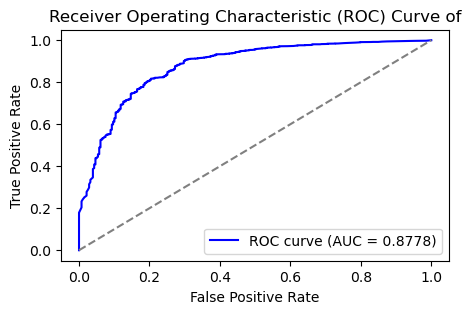

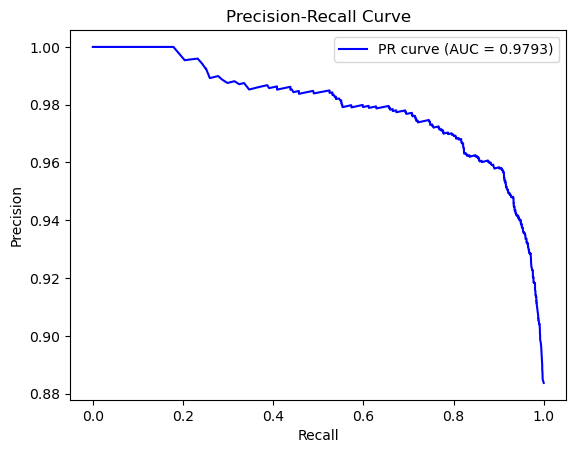

 RANDOM FOREST 
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.35      0.80      0.49       279
        True       0.97      0.81      0.88      2120

    accuracy                           0.81      2399
   macro avg       0.66      0.80      0.68      2399
weighted avg       0.90      0.81      0.83      2399


F1 Score:      0.8804

AUC-ROC Score: 0.8778

ACCURACY:      0.8062

PRECISION:      0.9683

RECALL:      0.8071
Cross-validation accuracy for all features XGB: 0.8260


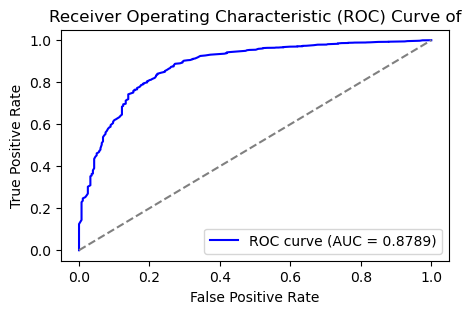

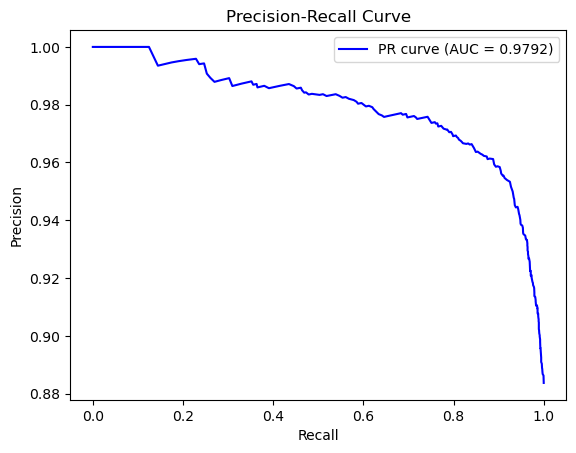

 

XGBOOST  
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.36      0.79      0.50       279
        True       0.97      0.82      0.89      2120

    accuracy                           0.81      2399
   macro avg       0.67      0.80      0.69      2399
weighted avg       0.90      0.81      0.84      2399


F1 Score:      0.8866

AUC-ROC Score: 0.8789

ACCURACY:      0.8149

PRECISION:      0.9671

RECALL:      0.8184
Confusion Matrix
 [[ 220   59]
 [ 385 1735]]
Cross-validation accuracy for all features QDA: 0.8280


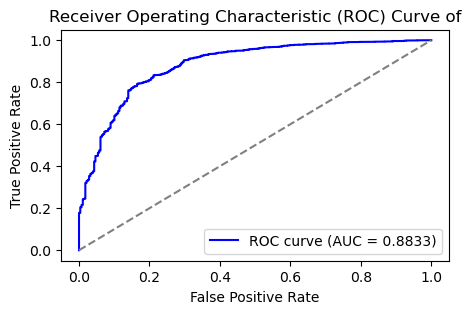

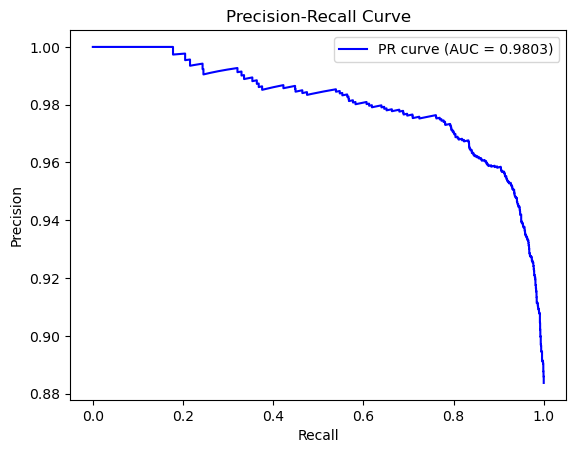

 

QUADRATIC DISCRIMINANT ANALYSIS 
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.39      0.75      0.51       279
        True       0.96      0.84      0.90      2120

    accuracy                           0.83      2399
   macro avg       0.68      0.80      0.71      2399
weighted avg       0.90      0.83      0.85      2399


F1 Score:      0.8997

AUC-ROC Score: 0.8833

ACCURACY:      0.8337

PRECISION:      0.9629

RECALL:      0.8443
Confusion Matrix
 [[ 210   69]
 [ 330 1790]]
Cross-validation accuracy for all features stacking_model: 0.5207


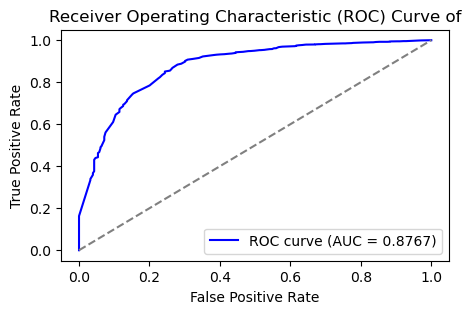

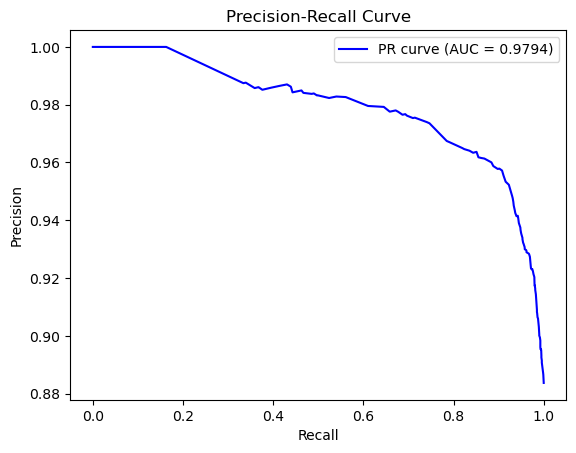

 

STACKING MODEL(RANDOM FOREST + XGBOOST)
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.77      0.04      0.07       279
        True       0.89      1.00      0.94      2120

    accuracy                           0.89      2399
   macro avg       0.83      0.52      0.50      2399
weighted avg       0.87      0.89      0.84      2399


F1 Score:      0.9396

AUC-ROC Score: 0.8767

ACCURACY:      0.8866

PRECISION:      0.8873

RECALL:      0.9986
Confusion Matrix
 [[  10  269]
 [   3 2117]]
Cross-validation accuracy for all features voting_clf_soft: 0.6177


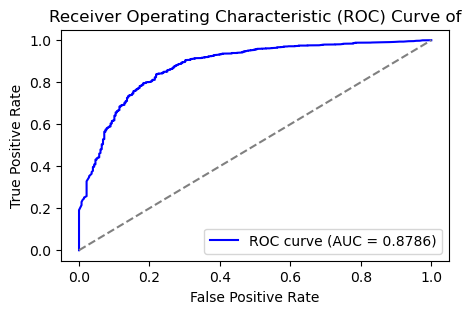

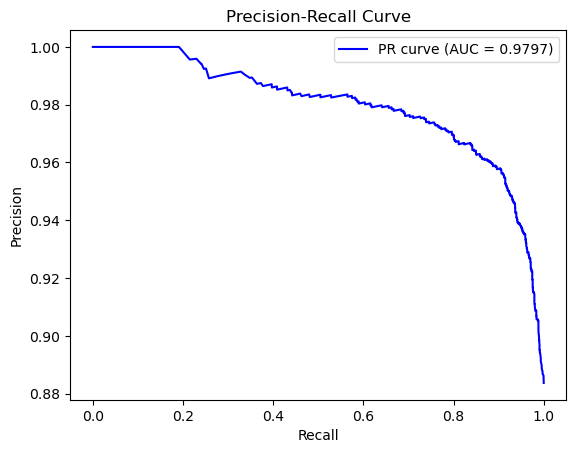

 

VOTING MODEL(RANDOM FOREST + XGBOOST) 
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.66      0.23      0.34       279
        True       0.91      0.98      0.94      2120

    accuracy                           0.90      2399
   macro avg       0.78      0.61      0.64      2399
weighted avg       0.88      0.90      0.87      2399


F1 Score:      0.9439

AUC-ROC Score: 0.8786

ACCURACY:      0.8966

PRECISION:      0.9070

RECALL:      0.9840
Confusion Matrix
 [[  65  214]
 [  34 2086]]


In [29]:
classifier,cm,accuracy_rf,precision_rf,recall_rf,clr,f1_rf,roc_auc_rf=Random(x_train,y_train,x_test)
print(" RANDOM FOREST ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_rf:.4f}")
print(f"\nAUC-ROC Score: {roc_auc_rf:.4f}")
print(f"\nACCURACY:      {accuracy_rf:.4f}")
print(f"\nPRECISION:      {precision_rf:.4f}")
print(f"\nRECALL:      {recall_rf:.4f}")
classifier,cm,accuracy_xgb,precision_xgb,recall_xgb,clr,f1_xgb,roc_auc_xgb=XGB(x_train,y_train,x_test)
print(" \n\nXGBOOST  ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_xgb:.4f}")
print(f"\nAUC-ROC Score: {roc_auc_xgb:.4f}")
print(f"\nACCURACY:      {accuracy_xgb:.4f}")
print(f"\nPRECISION:      {precision_xgb:.4f}")
print(f"\nRECALL:      {recall_xgb:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_qda,precision_qda,recall_qda,clr,f1_qda,roc_auc_qda=QDA(x_train,y_train,x_test)
print(" \n\nQUADRATIC DISCRIMINANT ANALYSIS ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_qda:.4f}")
print(f"\nAUC-ROC Score: {roc_auc_qda:.4f}")
print(f"\nACCURACY:      {accuracy_qda:.4f}")
print(f"\nPRECISION:      {precision_qda:.4f}")
print(f"\nRECALL:      {recall_qda:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_stacking,precision_stacking,recall_stacking,clr,f1_stacking,roc_auc_stacking=stack(x_train,y_train,x_test)
print(" \n\nSTACKING MODEL(RANDOM FOREST + XGBOOST)")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_stacking:.4f}")
print(f"\nAUC-ROC Score: {roc_auc_stacking:.4f}")
print(f"\nACCURACY:      {accuracy_stacking:.4f}")
print(f"\nPRECISION:      {precision_stacking:.4f}")
print(f"\nRECALL:      {recall_stacking:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_voting,precision_voting,recall_voting,clr,f1_voting,roc_auc_voting=voting_clf_soft(x_train,y_train,x_test)
print(" \n\nVOTING MODEL(RANDOM FOREST + XGBOOST) ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_voting:.4f}")
print(f"\nAUC-ROC Score: {roc_auc_voting:.4f}")
print(f"\nACCURACY:      {accuracy_voting:.4f}")
print(f"\nPRECISION:      {precision_voting:.4f}")
print(f"\nRECALL:      {recall_voting:.4f}")
print("Confusion Matrix\n",cm)


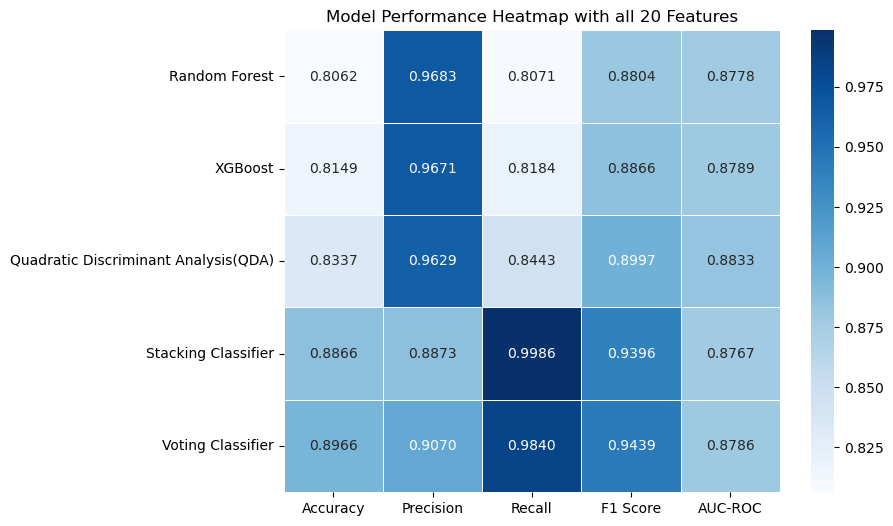

In [30]:
data = {
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_qda, accuracy_stacking,accuracy_voting],
    'Precision': [precision_rf, precision_xgb, precision_qda, precision_stacking,precision_voting],
    'Recall': [recall_rf, recall_xgb, recall_qda, recall_stacking,recall_voting],
    'F1 Score': [f1_rf, f1_xgb, f1_qda, f1_stacking,f1_voting],
    'AUC-ROC': [roc_auc_rf, roc_auc_xgb, roc_auc_qda, roc_auc_stacking,roc_auc_voting]
}

# Create a DataFrame
df = pd.DataFrame(data, index=['Random Forest','XGBoost','Quadratic Discriminant Analysis(QDA)','Stacking Classifier','Voting Classifier'])

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='Blues', fmt='.4f', linewidths=0.5)
plt.title('Model Performance Heatmap with all 20 Features')
plt.show()

For top 10 features

Cross-validation accuracy for all features RFC: 0.9305


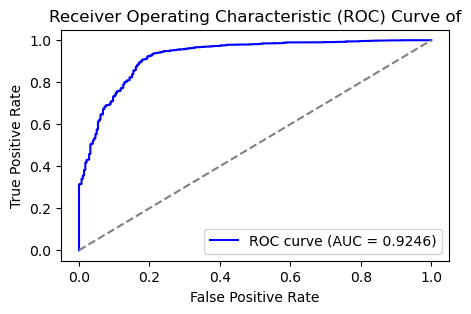

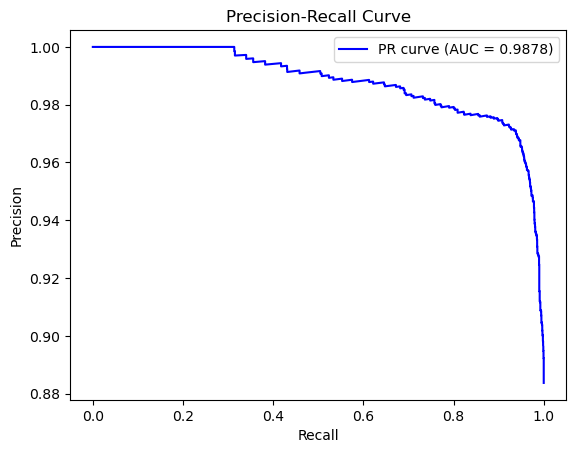

 RANDOM FOREST 
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.64      0.76      0.70       279
        True       0.97      0.94      0.96      2120

    accuracy                           0.92      2399
   macro avg       0.81      0.85      0.83      2399
weighted avg       0.93      0.92      0.93      2399


F1 Score:      0.9561

ROC-AUC Score: 0.9246

ACCURACY:      0.9233

PRECISION:      0.9676

RECALL:      0.9448
Confusion Matrix
 [[ 212   67]
 [ 117 2003]]
Cross-validation accuracy for all features XGB: 0.9494


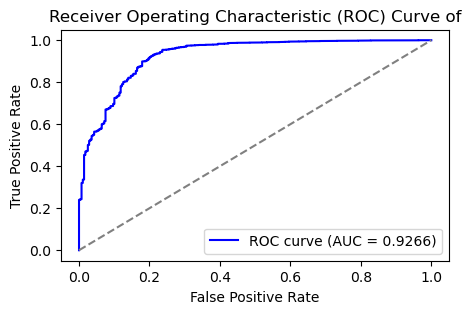

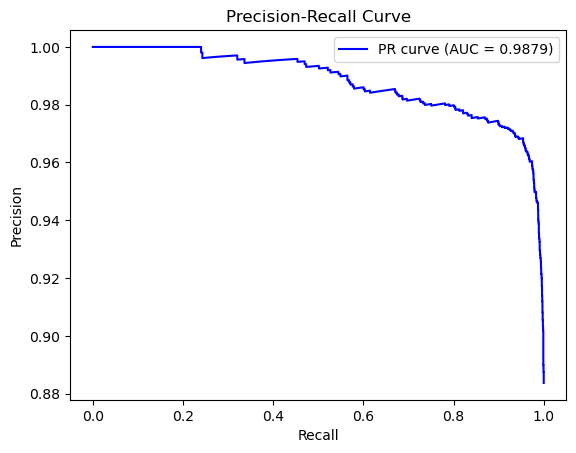

 

XGBOOST  
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.74      0.71      0.72       279
        True       0.96      0.97      0.96      2120

    accuracy                           0.94      2399
   macro avg       0.85      0.84      0.84      2399
weighted avg       0.94      0.94      0.94      2399


F1 Score:      0.9645

ROC-AUC Score: 0.9266

ACCURACY:      0.9371

PRECISION:      0.9624

RECALL:      0.9665
Confusion Matrix
 [[ 199   80]
 [  71 2049]]
Cross-validation accuracy for all features QDA: 0.8620


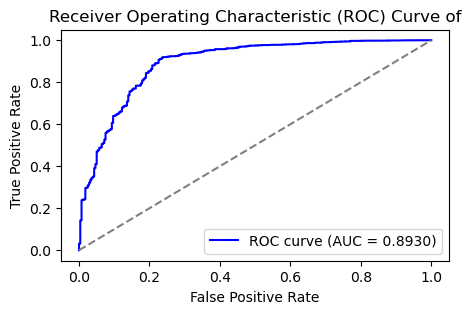

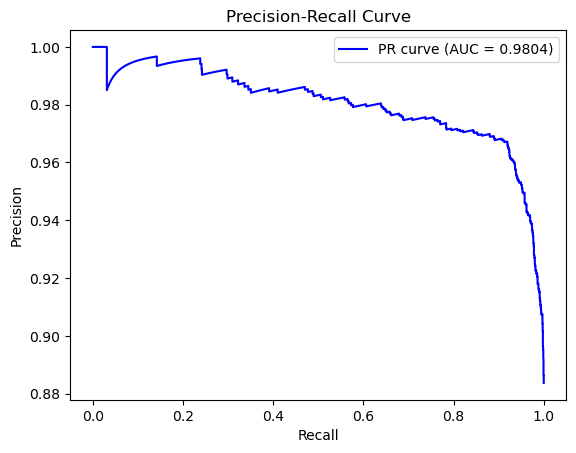

 

QUADRATIC DISCRIMINANT ANALYSIS 
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.52      0.77      0.62       279
        True       0.97      0.91      0.94      2120

    accuracy                           0.89      2399
   macro avg       0.75      0.84      0.78      2399
weighted avg       0.92      0.89      0.90      2399


F1 Score:      0.9367

ROC-AUC Score: 0.8930

ACCURACY:      0.8916

PRECISION:      0.9678

RECALL:      0.9075
Confusion Matrix
 [[ 215   64]
 [ 196 1924]]
Cross-validation accuracy for all features stacking_model: 0.7360


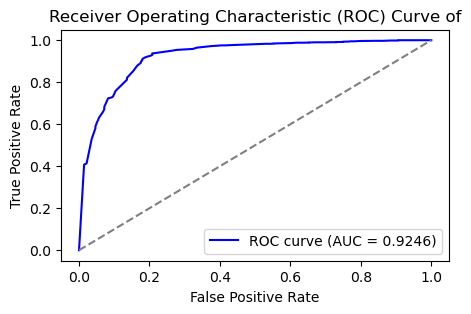

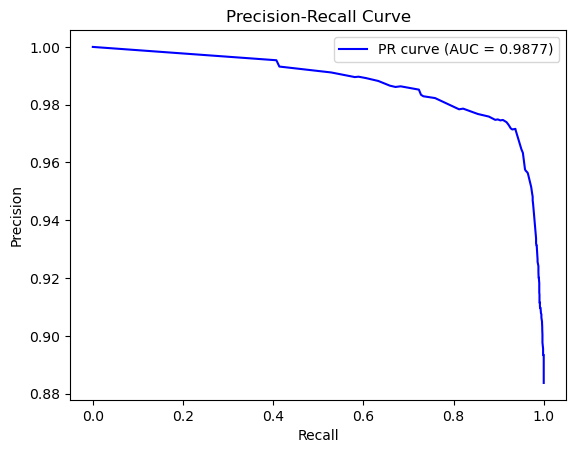

 

STACKING MODEL(RANDOM FOREST + XGBOOST)
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.89      0.12      0.21       279
        True       0.90      1.00      0.94      2120

    accuracy                           0.90      2399
   macro avg       0.90      0.56      0.58      2399
weighted avg       0.90      0.90      0.86      2399


F1 Score:      0.9444

ROC-AUC Score: 0.9246

ACCURACY:      0.8962

PRECISION:      0.8962

RECALL:      0.9981
Confusion Matrix
 [[  34  245]
 [   4 2116]]
Cross-validation accuracy for all features voting_clf_soft: 0.9104


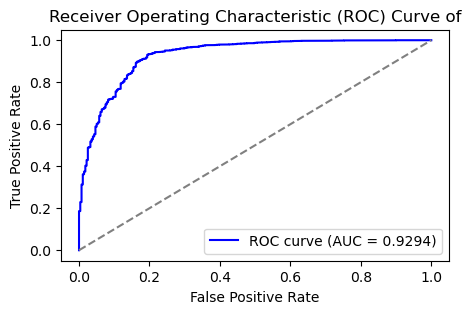

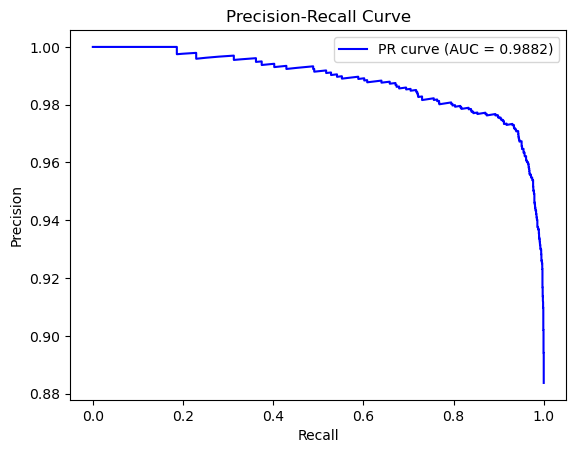

 

VOTING MODEL(RANDOM FOREST + XGBOOST) 
         
CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.94      0.37      0.53       279
        True       0.92      1.00      0.96      2120

    accuracy                           0.92      2399
   macro avg       0.93      0.68      0.74      2399
weighted avg       0.92      0.92      0.91      2399


F1 Score:      0.9585

ROC-AUC Score: 0.9294

ACCURACY:      0.9237

PRECISION:      0.9231

RECALL:      0.996698
Confusion Matrix
 [[ 103  176]
 [   7 2113]]


In [31]:
print("For top 10 features\n")
classifier,cm,accuracy_rf,precision_rf,recall_rf,clr,f1_rf,roc_auc_rf=Random(x_train_selected,y_train,x_test_selected)
print(" RANDOM FOREST ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_rf:.4f}")
print(f"\nROC-AUC Score: {roc_auc_rf:.4f}")
print(f"\nACCURACY:      {accuracy_rf:.4f}")
print(f"\nPRECISION:      {precision_rf:.4f}")
print(f"\nRECALL:      {recall_rf:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_xgb,precision_xgb,recall_xgb,clr,f1_xgb,roc_auc_xgb=XGB(x_train_selected,y_train,x_test_selected)
print(" \n\nXGBOOST  ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_xgb:.4f}")
print(f"\nROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"\nACCURACY:      {accuracy_xgb:.4f}")
print(f"\nPRECISION:      {precision_xgb:.4f}")
print(f"\nRECALL:      {recall_xgb:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_qda,precision_qda,recall_qda,clr,f1_qda,roc_auc_qda=QDA(x_train_selected,y_train,x_test_selected)
print(" \n\nQUADRATIC DISCRIMINANT ANALYSIS ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_qda:.4f}")
print(f"\nROC-AUC Score: {roc_auc_qda:.4f}")
print(f"\nACCURACY:      {accuracy_qda:.4f}")
print(f"\nPRECISION:      {precision_qda:.4f}")
print(f"\nRECALL:      {recall_qda:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_stacking,precision_stacking,recall_stacking,clr,f1_stacking,roc_auc_stacking=stack(x_train_selected,y_train,x_test_selected)
print(" \n\nSTACKING MODEL(RANDOM FOREST + XGBOOST)")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_stacking:.4f}")
print(f"\nROC-AUC Score: {roc_auc_stacking:.4f}")
print(f"\nACCURACY:      {accuracy_stacking:.4f}")
print(f"\nPRECISION:      {precision_stacking:.4f}")
print(f"\nRECALL:      {recall_stacking:.4f}")
print("Confusion Matrix\n",cm)
classifier,cm,accuracy_voting,precision_voting,recall_voting,clr,f1_voting,roc_auc_voting=voting_clf_soft(x_train_selected,y_train,x_test_selected)
print(" \n\nVOTING MODEL(RANDOM FOREST + XGBOOST) ")
print("         \nCLASSIFICATION REPORT\n")
print(clr)
print(f"\nF1 Score:      {f1_voting:.4f}")
print(f"\nROC-AUC Score: {roc_auc_voting:.4f}")
print(f"\nACCURACY:      {accuracy_voting:.4f}")
print(f"\nPRECISION:      {precision_voting:.4f}")
print(f"\nRECALL:      {recall_voting:.6f}")
print("Confusion Matrix\n",cm)

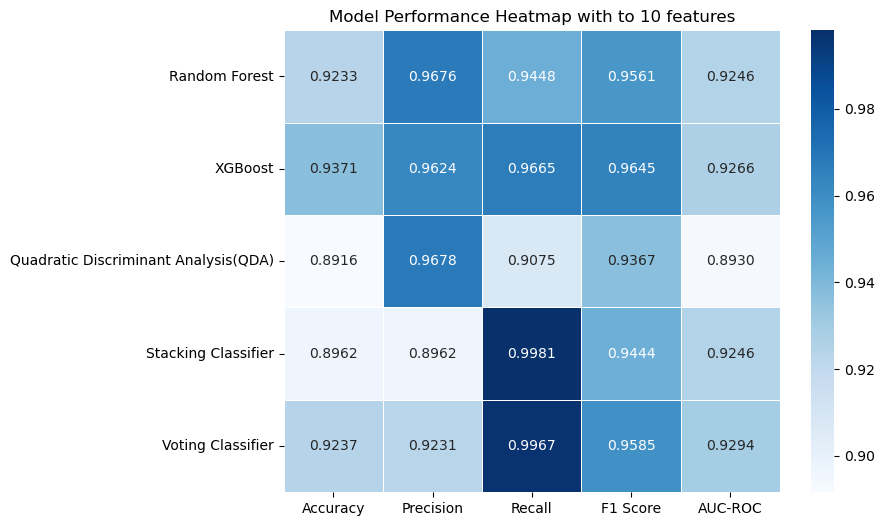

In [32]:
data = {
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_qda, accuracy_stacking,accuracy_voting],
    'Precision': [precision_rf, precision_xgb, precision_qda, precision_stacking,precision_voting],
    'Recall': [recall_rf, recall_xgb, recall_qda, recall_stacking,recall_voting],
    'F1 Score': [f1_rf, f1_xgb, f1_qda, f1_stacking,f1_voting],
    'AUC-ROC': [roc_auc_rf, roc_auc_xgb, roc_auc_qda, roc_auc_stacking,roc_auc_voting]
}

# Create a DataFrame
df = pd.DataFrame(data, index=['Random Forest','XGBoost','Quadratic Discriminant Analysis(QDA)','Stacking Classifier','Voting Classifier'])

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='Blues', fmt='.4f', linewidths=0.5)
plt.title('Model Performance Heatmap with to 10 features')
plt.show()